# Regression Example - California Housing<a class="anchor" id="top"></a>

### Notebook by Justin Bandoro

In this notebook, we will be working with a dataset obtained from Aurélien Géron's book *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, [Chapter 2](https://github.com/ageron/handson-ml/blob/master/datasets/housing/housing.csv). The data analysis and model developing is mostly following along with the textbook, but I explore and deviate as well.



<img src='la_image.jpg'>
*Los Angeles, image from [HousingWire](https://www.housingwire.com/articles/37316-reasons-why-california-housing-is-about-to-grind-slower)*

## Table of Contents:

1. [Framing the problem](#frameproblem)
2. [Loading the data](#getdata)
3. [Checking the data](#checkdata)
4. [Explore the data](#explore)
5. [Training and test sets](#traintest)
6. [Visualize the training data](#visualize)
7. [Feature engineering testing](#featureng)
8. [Data preperation](#preperation)
9. [Transformer pipelines](#pipelines)
10. [Select and Train a Model](#firstmodels)
11. [Model baselines](#baselines)
12. [Fine-tuning hyperparameters](#gridsearch)
13. [Analyzing the best estimators](#bestestimators)
14. [Evaluate system on test data](#evaluatetesth)
14. [Summary](#summary)



## 1. Framing the problem <a class="anchor" id="frameproblem"></a>
[[back to top]](#top)

The task at hand is to construct a model of housing prices in California using the California census data which contains features such as population, median income, median housing price, etc. for each district in California. The objective is to predict the median housing price in any district givien all other metrics

We can define the problem in terms of how would a business expect to benefit from a model we construct:

*"The business you are working for will use model output as part of a larger project that will use output into another machine learning system to determine if it is worth investing in the area or not. District pricing from the model you construct will be a critical piece!"*

#### What is the current solution?
Good idea to get reference performance, and how to solve problem. The business says that district housing prices are estimated by experts, where they gather information and use complex rules to get an estimate with a typical error of 15%. 


#### What type of problem is it?
This is a supervised learning problem since the dataset has known labels (median housing price). It is also a multivariate regression problem since we'll have to predict a value from multiple features/attributes. There is no incoming data to update our model, and the data is small enough to fit into memory so can use batch learning. 

#### What performance metric should be used?
The most common scoring metric for regression problems is the RMSE, which is standard deviation of errors the system makes in the predictions. E.g. an RMSE of `$`50,000 means 68`%` of the predictions fall within `$`50,000 of the actual value, and 95% within `$`100,000. RMSE is the cost function we want to minimize. Though if we find there are many outliers we may want to use the Mean Absolute Error 


## 2. Loading the data <a class="anchor" id="getdata"></a>
[[back to top]](#top)

Load workspace and import the data.

In [1]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('precision',1) #easy to read output

# Load data 
data  = pd.read_csv('housing.csv')
print('California Housing Data')
display(data.head())

California Housing Data


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.2,37.9,41.0,880.0,129.0,322.0,126.0,8.3,452600.0,NEAR BAY
1,-122.2,37.9,21.0,7099.0,1106.0,2401.0,1138.0,8.3,358500.0,NEAR BAY
2,-122.2,37.9,52.0,1467.0,190.0,496.0,177.0,7.3,352100.0,NEAR BAY
3,-122.2,37.9,52.0,1274.0,235.0,558.0,219.0,5.6,341300.0,NEAR BAY
4,-122.2,37.9,52.0,1627.0,280.0,565.0,259.0,3.8,342200.0,NEAR BAY


We have the following 9 attributes for each district:

1. longitude: numerical
2. latitude: numerical
3. housing_median_age: numerical
4. total_rooms: numerical
5. total_bedrooms: numerical
6. population: numerical
7. households: numerical
8. median_income: numerical 
9. ocean_proximity: categorical     

## 3. Checking the data<a class="anchor" id="checkdata"></a>
[[back to top]](#top)

Here we will look at the data and check the number if there are missing values. We will also see what the different values are for the categorical features (ocean_proximity).

In [2]:
print('Data types:')
display(data.dtypes)
print('Missing values:')
display(data.isnull().sum() )
print('Numerical feature stats:')
display(data.describe())
print('Categorical feature stats:')
[data[c].value_counts() for c in list(data.select_dtypes(include=['O','category']).columns)]

Data types:


longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Missing values:


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Numerical feature stats:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-119.6,35.6,28.6,2635.8,537.9,1425.5,499.5,3.9,206855.8
std,2.0,2.1,12.6,2181.6,421.4,1132.5,382.3,1.9,115395.6
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1447.8,296.0,787.0,280.0,2.6,119600.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179700.0
75%,-118.0,37.7,37.0,3148.0,647.0,1725.0,605.0,4.7,264725.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


Categorical feature stats:


[<1H OCEAN     9136
 INLAND        6551
 NEAR OCEAN    2658
 NEAR BAY      2290
 ISLAND           5
 Name: ocean_proximity, dtype: int64]

#### Data Notes: 

We have 20,640 instances/samples in the dataset.

We see that there are 207 missing values for total_bedrooms that we'll have to deal with later. We could investigate using the total_rooms as a way to impute it.

There are 5 categorical values for ocean proximity that we see above.


## 4. Exploring the data <a class="anchor" id="explore"></a>
[[back to top]](#top)

It is a good idea to visualize to see if there are any outliers/errors/quirks in the data, and to get a general sense of the distribution of the numerical attributes.

/Users/Justin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


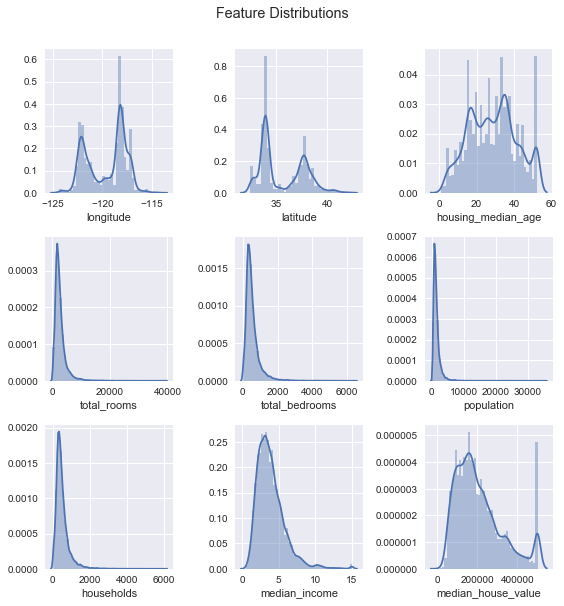

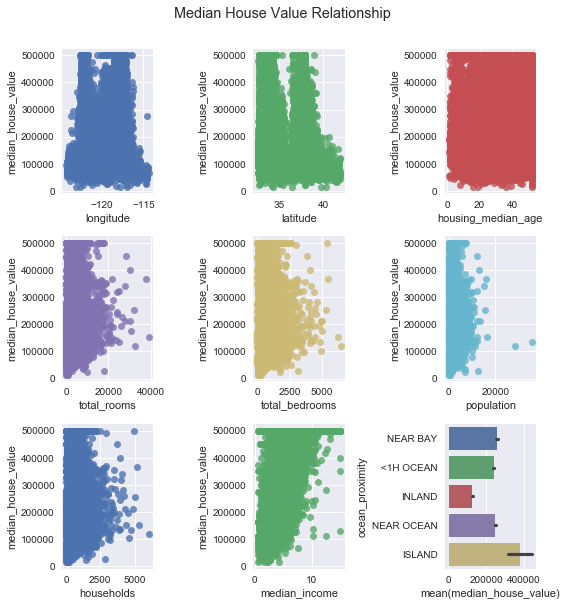

In [3]:
# Distribution plots of numerical features
feat_num = data.select_dtypes(include=[np.number]).columns.values
feat_cat = ['ocean_proximity']
fig1,axes1 = plt.subplots(3,3,figsize=[8,8])
for ax1,feat in zip(axes1.ravel(),feat_num ):
    sns.distplot(data[feat].dropna(),ax=ax1)
fig1.tight_layout()

# Scatter and barplots for relationship to housing price
fig2,axes2 = plt.subplots(3,3,figsize=[8,8])
fig1.suptitle('Feature Distributions',y=1.05)
fig2.suptitle('Median House Value Relationship',y=1.05)
for ax2,feat in zip(axes2.ravel(),feat_num[feat_num!='median_house_value']):
    sns.regplot(x=feat,y='median_house_value',data=data.dropna(),ax=ax2,fit_reg=False)
sns.barplot(y='ocean_proximity',x='median_house_value',data=data.dropna(),ax=axes2.ravel()[-1])
fig2.tight_layout();fig2.tight_layout()

#### What do we see from quick data exploration:

From the histograms, we see that there are a few interesting features we should take note of. The first is that the `median_house_age` and `median_house_value` have been capped at a maximum value of 52 years and `$`500,001 where any values larger have been recorded as those values. We would expect there to be a tail in the distribution. This can be problematic if we are required output for predictions greater than `$`500,000. We could remove the districts in the last bin from the training set.

The scale ranges of the attributes vary several orders of magnitude so we will have to scale when preprocessing the data. Also a few of the features such as total_rooms, total_bedrooms and households are tail heavy which may make machine learning a bit harder to detect patterns. So we may want to transform these features as well in the preprocessing.

Below let us quickly look at the correlation in the dataset.

#### Correlation Heatmap:

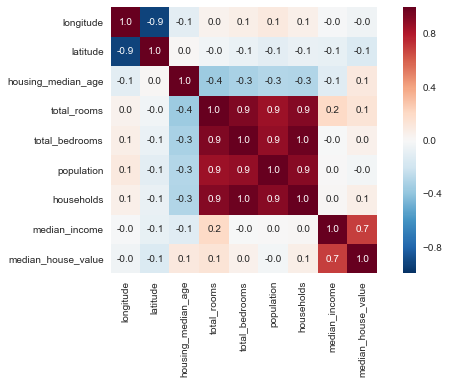

In [4]:
correlations = data.corr()
sns.heatmap(correlations, square=True,annot=True,fmt='.1f',annot_kws={'size':10})
plt.tight_layout()

The simple correlation matrix above allows us to see which features are co-linearly related and which ones have highest correlation with median_house_value. We see that longitude and latitude are tightly coupled, as expected, and also `total_rooms`/`total_bedrooms`/`population`/`households` are highly correlated with eachother. 

If we want to impute missing values of `total_bedrooms`, `households` or `total_rooms` can be used.  

Lastly the feature that has the highest correlation with `median_house_value` is the `median_income`. 

## 5. Training and test sets <a class="anchor" id="traintest"></a>
[[back to top]](#top)

To avoid leaking of test data into our training set we use for model development, we will split our dataset into training and test sets. Since we have a relatively large dataset, we can use the common 80/20 split. As we saw in the correlation heatmap, `median_income` is the highest correlated feature with `median_house_value`. 

We could randomly split the dataset we have, but we would like to ensure that the test set is representative of the median income levels. In classification and regression problems we split so that the target label is not biased in either the training and/or test set.

To do this we'll add a new feature for `income_levels` that is calculated by dividing the `median_income` by 1.5 (to limit the number of income categories) and rounding up using `np.ceil`, and placing all values greater than 5 into category 5. 

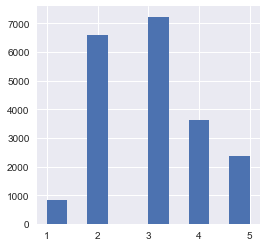

In [5]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

data['income_levels'] = np.ceil(data.median_income/1.5)
data.ix[data.income_levels > 5, 'income_levels'] = 5
data.income_levels.hist(figsize=[4,4])

We will split the dataset into training and test sets based on the `income_levels` distribution above. 

Full dataset:


3.0    3.5e-01
2.0    3.2e-01
4.0    1.8e-01
5.0    1.1e-01
1.0    4.0e-02
Name: income_levels, dtype: float64

Train set:


3.0    3.5e-01
2.0    3.2e-01
4.0    1.8e-01
5.0    1.1e-01
1.0    4.0e-02
Name: income_levels, dtype: float64

Test set:


3.0    3.5e-01
2.0    3.2e-01
4.0    1.8e-01
5.0    1.1e-01
1.0    4.0e-02
Name: income_levels, dtype: float64

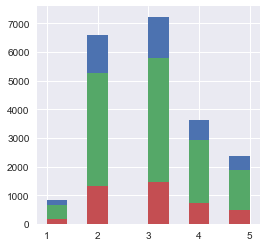

In [6]:
X = data.drop(['median_house_value'],axis=1); y = data['median_house_value']

#Size for train/test split by income levels
test_size = 0.2
splitter  = StratifiedShuffleSplit(n_splits=1,test_size=test_size,random_state=7)
for train_index, test_index in splitter.split(X, X.income_levels):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Visually ensure distributions of income levels are similar
X.income_levels.hist(figsize=[4,4])
X_train.income_levels.hist()
X_test.income_levels.hist()

# Print relative fraction 
print('Full dataset:')
display(X.income_levels.value_counts()/len(X))
print('Train set:')
display(X_train.income_levels.value_counts()/len(X_train))
print('Test set:')
display(X_test.income_levels.value_counts()/len(X_test))

# Remove income_levels
X_train = X_train.drop(['income_levels'],axis=1)
X_test  = X_test.drop(['income_levels'],axis=1)
data    = data.drop(['income_levels'],axis=1)

Can see in the plot and in the fractional print out that the split by `income_levels` is maintained in the training and test sets.

## 6. Visualize the training data <a class="anchor" id="visualize"></a>
[[back to top]](#top)

Since we have only quickly looked at the data above, we will go into more detail in this part. 

### Geographically visualizations
We have latitude and longitude so we can look where all of the districts are located, and the density.

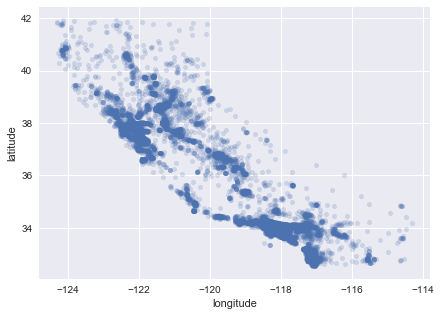

In [7]:
# Map of district density
X_train.plot(kind='scatter',x='longitude',y='latitude',alpha=0.2,figsize=[7,5])

The above looks like California (one would hope!) and we can identify the density of the districts concentrated around the Bay Area, Los Angeles and San Diego. 

Next we'll add more detail to the map so that the size of the marker represents the district population and the color represents the median house value.

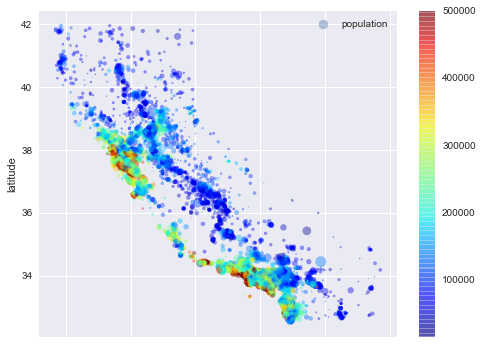

In [8]:
# Add size to district based on population and color based on median house value
X_train.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=X_train.population/100,
        label='population',c=y_train,cmap=plt.get_cmap('jet'),colorbar=True,figsize=[8,6])

The above informs us that housing price is highly location dependent, districts closer to the coast are usually more expensive. Also the higher the population density (clustering of districts) the higher the median house value.

The proximity to the ocean attribute is useful since it captures the high house prices in the big-city districts, but that's not true every where. Near the north coast, the prices close to the ocean aren't as expensive.


## 7. Feature engineering testing<a class="anchor" id="featureng"></a>
[[back to top]](#top)

In this part we want to try to combine some of the features to make new ones. For example, the total number of rooms in a district is not very useful if you don't know how many households there are. There could be many small houses or fewer large houses. We really want to know the number of rooms per household. We can also look at the bedroom per room ratio and can try out population per household.

In [9]:
# Add attributes to copy dataset for testing
X_train_copy = X_train.copy() # add attributes to test first
X_train_copy['rooms_per_house'] = X_train_copy.total_rooms/X_train_copy.households
X_train_copy['bedrooms_per_room'] = X_train_copy.total_bedrooms/X_train_copy.total_rooms
X_train_copy['population_per_house'] = X_train_copy.population/X_train_copy.households
X_train_copy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_per_room,population_per_house
12448,-114.7,33.6,28.0,1678.0,322.0,666.0,256.0,3.0,INLAND,6.6,0.2,2.6
2745,-115.6,32.8,34.0,1152.0,208.0,621.0,208.0,3.6,INLAND,5.5,0.2,3.0
2949,-119.0,35.4,31.0,2931.0,716.0,1969.0,588.0,2.2,INLAND,5.0,0.2,3.3
11792,-121.2,38.8,21.0,3691.0,640.0,1758.0,603.0,3.6,INLAND,6.1,0.2,2.9
14485,-117.3,32.9,25.0,2355.0,381.0,823.0,358.0,6.8,NEAR OCEAN,6.6,0.2,2.3


We can then see if there is improved correlation with the district house value when comparing the the total_bedrooms/rooms/population to the values per household.

In [10]:
# Calculate Correlations
X_train_copy['house_price'] = y_train
correlations = X_train_copy.corr()
correlations['house_price'].sort_values(ascending=False)

house_price             1.0e+00
median_income           6.9e-01
rooms_per_house         1.5e-01
total_rooms             1.3e-01
housing_median_age      1.1e-01
households              6.6e-02
total_bedrooms          5.0e-02
population_per_house   -2.2e-02
population             -2.5e-02
longitude              -4.6e-02
latitude               -1.5e-01
bedrooms_per_room      -2.5e-01
Name: house_price, dtype: float64

From the above we can note that:

1. `rooms_per_house` is more informative than the `total_rooms` in a district. This makes sense, as the larger the house the more expensive is should be.
2. `bedrooms_per_room` is negatively correlated with house price, i.e. the lower the bedroom/room ratio, the more expensive the house is. This feature is more corelated than the `total_rooms` and `total_bedrooms`.

When preparing the data we may want to add these new features to the training set.

## 8. Data preperation <a class="anchor" id="preperation"></a>
[[back to top]](#top)

### Imputing missing values:

We cannot work with missing values in most machine learning algorithms. As seen earlier 207 out of the 20,640 `total_bedroom` instances are missing from the dataset. There are different options we can persue:

1. Get rid of the corresponding districts: `X_train.dropna(subset=['total_bedrooms']`
2. Get rid of the whole attribute: `X_train.drop('total_bedrooms',axis=1)`
3. Impute missing values with median: `X_train['total_bedrooms'].fillna(X_train.total_bedrooms.median() )`
4. Impute with knowledge of other attributes that are highly correlated with `total_bedrooms`. As we saw earlier, all of `households`, `total_rooms` and `population` are strongly correlated features with `total_bedrooms`. 

We will use the last approach. Note that we will derive a relationship from the training dataset and apply the same to the test. To begin we will see which attribute to use for imputing.

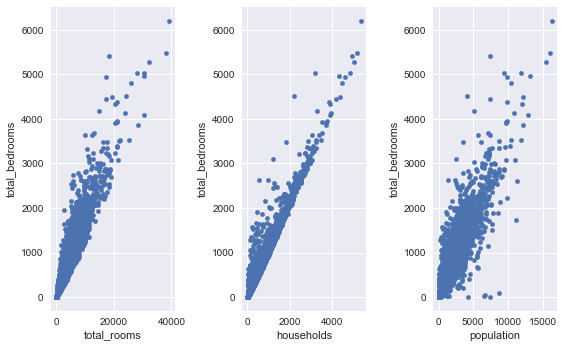

In [11]:
fig,(axes) = plt.subplots(1,3,figsize=[8,5])
for ax,var in zip (axes.ravel(),['total_rooms','households','population']):
    X_train.plot(kind='scatter',x=var, y='total_bedrooms', style='o',ax=ax)
fig.tight_layout()

If we were to do a 1st degree polynomial fit for `total_bedrooms`, from the above it looks like `total_rooms` would be the best choice since `households` is not evenly distributed and `population` has more spread.

Below we created a `BedroomImputer` class that we can use in future pipelines for data preperation, it saves the regression coefficients from the training data to impute missing values in test data.

In [12]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion

class BedroomImputer(BaseEstimator,TransformerMixin):
    """ Imputer that uses the fitted data to get the coefficients of a 1st degree
        polynomial to use for imputing total_bedrooms from total_rooms
    """
    def __init__(self):
        pass
        
    def transform(self, X, *_):
        # Check for missing values of bedrooms
        miss = np.isnan(X.total_bedrooms)
        # No missing values
        if ~np.any(miss):
            return X 
        Xret = X.copy()
        # Total rooms corresponding to missing bedroom
        missrooms  = Xret.loc[Xret.total_bedrooms.isnull(),'total_rooms']
        bedroom_est     = self.a*missrooms + self.b
        Xret.loc[X.total_bedrooms.isnull(),'total_bedrooms'] = bedroom_est
        return Xret
    
    def fit(self,X, y=None):
        rooms = X.loc[X.total_bedrooms.notnull(),'total_rooms']
        bedrooms = X.loc[X.total_bedrooms.notnull(),'total_bedrooms']
        #Fit polynomial of degree 1 to total rooms and total bedrooms
        p = np.polyfit(rooms,bedrooms,1)
        self.a = p[0]
        self.b = p[1]
        return self

Let's quickly test the imputer to see how good of a job it does:

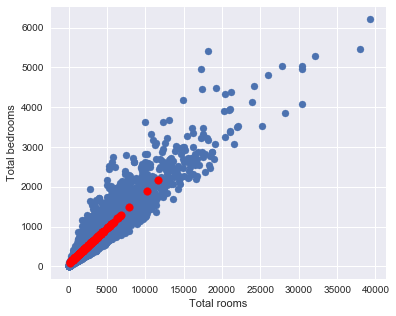

In [13]:
# Testing total_bedroom imputer
roomsDF = X_train[['total_rooms','total_bedrooms']]
missing = roomsDF.total_bedrooms.isnull()
narooms = roomsDF.loc[missing,'total_rooms']
imputed = BedroomImputer().fit_transform(roomsDF)
# Plotting imputed values with all instances
fig,ax = plt.subplots(1,figsize=[6,5])
ax.scatter(roomsDF.total_rooms[~missing],roomsDF.total_bedrooms[~missing])
ax.scatter(imputed.total_rooms[missing],imputed.total_bedrooms[missing],s=60,color='red')
ax.set_xlabel('Total rooms');ax.set_ylabel('Total bedrooms')

We can see that the bedroom imputer is doing a decent job and is certainly better than just using the median value for this case.

### More transformers:
Below are more transformers that we will use for this problem. They are good to have so that we can turn them on/off when tuning the model to see how much an effect they have on performance. The ones below are:

* **`CategoricalTransformer`**: one-hot encodes the categorical data in a dataframe
* **`CombinedAttributesAdder`**: as we did above, this is a compact way to add the additional per household/room attributes to the dataframe. We can turn on/off adding the new attributes.
* **`DataFrameSelector`**: selects attributes out of a dataframe, i.e. to seperate categorical from numerical features. Requires attribute names.
* **`DataFrameScaler`**: scales the numerical features of a dataframe. Input is the scaling class to use, i.e. `StandardScaler()` or `MinMaxScaler()`.
* **`DataFrameImputer`**: imputes missing values of a dataframe given by the strategy. This is a safeguard in addition to the `BedroomImputer` in case there is additional missing data in new datasets.

In [14]:
from itertools import chain
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer

class CategoricalTransformer(BaseEstimator,TransformerMixin):
    """ Taken from https://tomaugspurger.github.io/categorical-pipelines.html
    """
    def fit(self, X, y=None, *args, **kwargs):
        #Recast object to category type
        Xnew = pd.concat([
                    X.select_dtypes([], ['object']),
                    X.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
                    ], axis=1).reindex_axis(X.columns, axis=1)

        self.columns_ = Xnew.columns
        self.cat_columns_ = Xnew.select_dtypes(include=['category']).columns
        self.non_cat_columns_ = Xnew.columns.drop(self.cat_columns_)

        self.cat_map_ = {col: Xnew[col].cat.categories
                         for col in self.cat_columns_}
        self.ordered_ = {col: Xnew[col].cat.ordered
                         for col in self.cat_columns_}

        self.dummy_columns_ = {str(col): ["_".join([str(col), str(v)])
                                     for v in self.cat_map_[col]]
                               for col in self.cat_columns_}
        self.transformed_columns_ = pd.Index(
            self.non_cat_columns_.tolist() +
            list(chain.from_iterable(self.dummy_columns_[k]
                                     for k in self.cat_columns_))
        )
        return self

    def transform(self, X, y=None, *args, **kwargs):
        return (pd.get_dummies(X)
                  .reindex(columns=self.transformed_columns_)
                  .fillna(0))

    def inverse_transform(self, X):

        X = np.asarray(X)
        series = []
        non_cat_cols = (self.transformed_columns_
                            .get_indexer(self.non_cat_columns_))
        non_cat = pd.DataFrame(X[:, non_cat_cols],
                               columns=self.non_cat_columns_)
        for col, cat_cols in self.dummy_columns_.items():
            locs = self.transformed_columns_.get_indexer(cat_cols)
            codes = X[:, locs].argmax(1)
            cats = pd.Categorical.from_codes(codes, self.cat_map_[col],
                                             ordered=self.ordered_[col])
            series.append(pd.Series(cats, name=col))
        # concats sorts, we want the original order
        df = (pd.concat([non_cat] + series, axis=1)
                .reindex(columns=self.columns_))
        return df

    
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    """ Adds attributes by dividing total_rooms and population by household
        and also bedrooms by total rooms
    """
    rooms_ix,bedrooms_ix,population_ix,houshold_ix = [3,4,5,6]
    
    def __init__(self,add_bedrooms_per_room=True,add_rooms_per_household=True,add_pop_per_household=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_rooms_per_household= add_rooms_per_household
        self.add_pop_per_household = add_pop_per_household
        
    def fit(self,X,y=None):
        return self #nothing else to do
    
    def transform(self,X,y=None):
        Xtrans = X.copy()
        if self.add_bedrooms_per_room:
            Xtrans['bedrooms_per_room'] = Xtrans.total_bedrooms/Xtrans.total_rooms
        if self.add_rooms_per_household:
            Xtrans['rooms_per_household'] = Xtrans.total_rooms/Xtrans.households
        if self.add_pop_per_household:
            Xtrans['pop_per_household'] = Xtrans.population/Xtrans.households
        features = Xtrans.columns.names
        self.features = features
        return Xtrans
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """ Selects columns from a DataFrame given the attribute_names
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        return X[self.attribute_names]

class DataFrameScaler(BaseEstimator, TransformerMixin):
    """ Uses the sklearn scaler transformers but to operate on 
        dataframes and return dataframes instead of numpy arrays
    """
    def __init__(self,scaler = StandardScaler()):
        self.scaler = scaler
    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    def transform(self, X,y=None):
        Xtrans = self.scaler.transform(X)
        return pd.DataFrame(Xtrans,columns=X.columns.values)

class DataFrameLogger(BaseEstimator, TransformerMixin):
    """ Takes the log either exp or base10 of the columns
        in the dataframe
    """
    def __init__(self,base = '10',feats='all'):
        self.base  = base
        self.feats = feats
    def fit(self, X, y=None): # nothing to do
        return self
    def transform(self, X,y=None):
        if self.feats == 'all':
            feats = X.columns.values
        else:
            feats = self.feats
        Xtrans = X.copy()
        if self.base == 'exp':
            Xtrans[feats] = X[feats].apply(np.log)
        elif self.base == '10':
            Xtrans[feats] = X[feats].apply(np.log10)
        return Xtrans
    
    
class DataFrameImputer(BaseEstimator, TransformerMixin):
    """ Uses the sklearn imputer but also operates and returns
        dataframes instead of numpy arrays
    """
    def __init__(self,imputer= Imputer(strategy='median') ):
        self.imputer = imputer
    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self
    def transform(self, X,y=None):
        Xtrans = self.imputer.transform(X)
        return pd.DataFrame(Xtrans,columns=X.columns.values)

Now let's test the transformers we created above to ensure they are doing what we hope they would do:

One hot encoded data:


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12448,0,1,0,0,0
2745,0,1,0,0,0
2949,0,1,0,0,0
11792,0,1,0,0,0
14485,0,0,0,0,1


Imputed and scaled data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,2.5,-1.0,-5.6e-02,-0.4,-0.5,-0.7,-0.6,-0.5
1,2.0,-1.3,4.2e-01,-0.7,-0.8,-0.7,-0.8,-0.1
2,0.3,-0.1,1.8e-01,0.1,0.4,0.5,0.2,-0.9
3,-0.8,1.5,-6.1e-01,0.5,0.3,0.3,0.3,-0.2
4,1.1,-1.3,-2.9e-01,-0.1,-0.4,-0.6,-0.4,1.6


Added attributes to data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bedrooms_per_room,rooms_per_household,pop_per_household
12448,-114.7,33.6,28.0,1678.0,322.0,666.0,256.0,3.0,INLAND,0.2,6.6,2.6
2745,-115.6,32.8,34.0,1152.0,208.0,621.0,208.0,3.6,INLAND,0.2,5.5,3.0
2949,-119.0,35.4,31.0,2931.0,716.0,1969.0,588.0,2.2,INLAND,0.2,5.0,3.3
11792,-121.2,38.8,21.0,3691.0,640.0,1758.0,603.0,3.6,INLAND,0.2,6.1,2.9
14485,-117.3,32.9,25.0,2355.0,381.0,823.0,358.0,6.8,NEAR OCEAN,0.2,6.6,2.3


Log of data attributes:


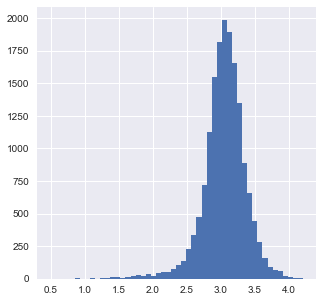

In [15]:
# Get numerical and categorical features
num_feats= X_train.select_dtypes(include=[np.number]).columns.values
cat_feats= X_train.select_dtypes(exclude=[np.number]).columns.values

# Select using DataFrameSelector
X_train_num = DataFrameSelector(num_feats).fit_transform(X_train)
X_train_cat = DataFrameSelector(cat_feats).fit_transform(X_train)

# One hot encode the categorical data
print('One hot encoded data:')
hotencoded = CategoricalTransformer().fit_transform(X_train_cat)
display(hotencoded.head() )

# Impute and scale the numerical data
print('Imputed and scaled data:')
scaled = DataFrameScaler().fit_transform( DataFrameImputer().fit_transform(X_train_num ) )
display(scaled.head() )

# Add attributes
print('Added attributes to data:')
added = CombinedAttributesAdder().fit_transform(X_train)
display(added.head() )

# Take log of certain attributes
print('Log of data attributes:')
logattr = ['total_rooms','total_bedrooms','population','households']
logged = DataFrameLogger(feats=logattr).fit_transform(X_train)
logged['population'].hist(bins=50,figsize=[5,5])

With all the transformers made we can then create pipelines to put them all together seemlessly.

## 9. Transformer Pipelines: <a class="anchor" id="pipelines"></a>
[[back to top]](#top)


Next we will use all of the transformers we discussed earlier and put them all into 2 pipelines: one for numerical and one for categorical features.

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer,RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone #copy pipelines

# Numerical and categorical features 
num_feats= X_train.select_dtypes(include=[np.number]).columns.values
cat_feats= X_train.select_dtypes(exclude=[np.number]).columns.values

num_pipeline = Pipeline([ ('selector', DataFrameSelector(num_feats)),
                  ('bedroom_imputer',BedroomImputer()),
                  ('median_imputer', DataFrameImputer(Imputer(strategy='median')) ), #incase any missing values
                  ('attrib_adder',  CombinedAttributesAdder() ),
                  ('logger' , DataFrameLogger(feats=['population','total_bedrooms','total_rooms','households']) ),
                  ('scaler',  DataFrameScaler(RobustScaler()) )    
                ])
cat_pipeline = Pipeline([ ('selector', DataFrameSelector(cat_feats)),
                  ('onehotencode',  CategoricalTransformer() )
                ])

full_pipeline = FeatureUnion(transformer_list = [
                    ("num_pipeline",num_pipeline),
                    ("cat_pipeline",cat_pipeline),
                ])

In [17]:
# Testing numerical pipeline
print('Testing numerical pipeline')
X_num = num_pipeline.fit_transform(X_train)
display( X_num.head() )

Testing numerical pipeline


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_room,rooms_per_household,pop_per_household
0,1.0,-0.2,-5.3e-02,-0.3,-0.4,-0.7,-0.6,-2.6e-01,-0.2,0.8,-0.3
1,0.8,-0.4,2.6e-01,-0.8,-1.0,-0.8,-0.9,3.1e-02,-0.4,0.2,0.2
2,-0.1,0.3,1.1e-01,0.4,0.6,0.7,0.5,-6.1e-01,0.6,-0.1,0.6
3,-0.7,1.2,-4.2e-01,0.7,0.5,0.5,0.5,1.1e-02,-0.5,0.6,0.1
4,0.3,-0.4,-2.1e-01,0.1,-0.2,-0.4,-0.2,1.5e+00,-0.6,0.8,-0.6


In [18]:
# Testing categorical pipeline
X_cat = cat_pipeline.fit_transform(X_train)
X_cat.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12448,0,1,0,0,0
2745,0,1,0,0,0
2949,0,1,0,0,0
11792,0,1,0,0,0
14485,0,0,0,0,1


In [19]:
# Testing combined pipeline
X_prepared = full_pipeline.fit_transform(X_train)
X_prepared.shape

(16512, 16)

We can see above that the output is what we expect when we link all of the pipelines together. We'll then use the pipeline output to train the machine learning algorithms.

## 10. Select and Train a Model<a class="anchor" id="firstmodels"></a>
[[back to top]](#top)

With the data processed and prepared we can begin to explore different learning algorithms. We will begin with a simple linear regression model.

### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

linreg_pipe = Pipeline([("features",clone(full_pipeline) ), ("reg", LinearRegression())])
linreg_pipe.fit(X_train,y_train)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'], dtype=object...ights=None)), ('reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

The pipeline contains all of the parameters for the transformers we used in preparation and for linear regression model. We can try out the linear regression model with a few instances from the training set:

In [21]:
# Testing on training data predictions
some_data =  X_train[0:4]
some_labels= y_train[0:4]
print('Predictions:\t',linreg_pipe.predict(some_data))
print('True values:\t',some_labels.values)

Predictions:	 [  68612.5252522   125982.26577658  106859.11520151  114563.66809096]
True values:	 [  94900.   73600.   62100.  151900.]


While we can see our predictions for the few instances how close they are to the true values, it would be better to have a performance metric for all of the training data. 

We will use RMSE on the whole training set and look at the performance:

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Predictions for full training data
housing_predictions = linreg_pipe.predict(X_train)
linreg_mse = mean_squared_error(y_train.values,housing_predictions)
print('Linear regression Training Scores:',np.sqrt(linreg_mse))

# Compare with cross-validation see below for details
scores = cross_val_score(linreg_pipe, X_train,y_train,scoring='neg_mean_squared_error',cv=10)
rmse = np.sqrt(-scores)
print('Linear regression C-V Scores: {} +/- {}'.format(np.mean(rmse),np.std(rmse) ) )

Linear regression Training Scores: 66050.6952585
Linear regression C-V Scores: 67244.10498035763 +/- 3413.6545177827834


This is an example of the model underfitting the training data since both the training and validation performances have high bias; a `$70,500` prediction error is not really useful. A few ways to address this are to select a more powerful/complex model, have more features, or reduce the constraints on the model.

#### Changing transformer parameters:
Before we try other models, remember we can use the transformers we created to change a few of the hyperparameters that generate the preprocessed data. 

In the two examples below we'll change the added attributes so that we don't add the population per household which was found to have low correlation. Also we'll skip the logging of the attributes to see if it actually makes a difference.

##### 1. No population_per_household

In [23]:
linreg_pipe.set_params(features__num_pipeline__attrib_adder__add_pop_per_household= False)
linreg_pipe.fit(X_train,y_train)
housing_predictions = linreg_pipe.predict(X_train)
linreg_mse = mean_squared_error(y_train.values,housing_predictions)
print('RMSE of training data:',np.sqrt(linreg_mse))

RMSE of training data: 66303.7720833


##### 2. No log transform

In [24]:
linreg_pipe.set_params(features__num_pipeline__attrib_adder__add_pop_per_household= True,
                       features__num_pipeline__logger = None)
linreg_pipe.fit(X_train,y_train)
housing_predictions = linreg_pipe.predict(X_train)
linreg_mse = mean_squared_error(y_train.values,housing_predictions)
print('RMSE of training data:',np.sqrt(linreg_mse))

RMSE of training data: 67638.6958622


Can see above that removing the population per household parameter increases the RMSE slightly, so more information (additional attributes) is better. Also not performing the log transform increases the RMSE, so we should keep it.

Next we'll look at another model type, a `DecisionTreeRegressor`:

### Decision Tree Regressor

This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [25]:
from sklearn.tree import DecisionTreeRegressor

dtree_pipe = Pipeline([("features",clone(full_pipeline) ), ("reg", DecisionTreeRegressor())])
dtree_pipe.fit(X_train,y_train)
housing_predictions = dtree_pipe.predict(X_train)
dtree_mse = mean_squared_error(y_train.values,housing_predictions)
print('RMSE of training data:',np.sqrt(dtree_mse))

RMSE of training data: 0.0


It seems like the decision tree is likely overfitting the training data, since it is perfect! But how can we confirm this?

### Cross-validation

**K-fold cross validation** randomly splits the training set into **K** distinct subsets called folds, then trains and evaluates the model **K** times choosing a different fold for evaluation and training on the other 9 folds. Resulting in 10 evaluation scores. We'll test this with the decision tree:

In [26]:
dtree_pipe = Pipeline([("features",clone(full_pipeline) ), ("reg", DecisionTreeRegressor())])
scores = cross_val_score(dtree_pipe, X_train,y_train,scoring='neg_mean_squared_error',cv=10)
rmse = np.sqrt(-scores)
print('Scores: {} +/- {}'.format(np.mean(rmse),np.std(rmse) ) )

Scores: 71353.24223728073 +/- 2015.7721617493764


Now we can confirm we were overfitting previously, C-V allows us to know the model performance and an estimate of the precision. 

Now we'll repeat but with a **Random Forest Regressor** which works by training many decision ensembles of decision trees. This is a subset of *Ensemble Learning*.

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([("features",clone(full_pipeline) ), ("reg", RandomForestRegressor())])
rf_pipe.fit(X_train,y_train)
predictions = rf_pipe.predict(X_train)
rmse = mean_squared_error(y_train.values, predictions)
print('Random Forest training score:',np.sqrt(rmse))

rf_pipe = Pipeline([("features",full_pipeline ), ("reg", RandomForestRegressor())])
scores = cross_val_score(rf_pipe, X_train,y_train,scoring='neg_mean_squared_error',cv=10)
rmse = np.sqrt(-scores)
print('Random Forest C-V Scores: {} +/- {}'.format(np.mean(rmse),np.std(rmse) ) )

Random Forest training score: 22396.05523
Random Forest C-V Scores: 53009.85715565613 +/- 1976.3027998308091


From the above results we see that the Random Forest validation scores are better than a single decision tree, but when compared to the training score it is still overfitting the training set.


## 11. Model baselines <a class="anchor" id="baselines"></a>
[[back to top]](#top)

Let's look at a bunch of other models without any hyperparameter tuning now to get an idea for a baseline and which ones are performing well relative to others, to improve speed a bit we will use 5-fold cross-validation. We will also compare the RMSE to using the model on the full training data to get an estimate of under/overfitting:

In [28]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#K-fold harness
num_folds = 5
kfold     = KFold(n_splits=num_folds,random_state = 7)

#All models
models = { 'RIDGE' : Ridge(alpha=100),
           'LR': LinearRegression(),
           'KNN':  KNeighborsRegressor(),
           'DTREE' : DecisionTreeRegressor(),
           'SVM': SVR(C=0.01),
           'RF': RandomForestRegressor()
        }
modelkeys = models.keys()

#Evaluate Models
CVResults = pd.DataFrame(columns=modelkeys)
TResults  = pd.DataFrame(columns=modelkeys)
scoring = 'neg_mean_squared_error'
for name in modelkeys:
    pipeline = Pipeline([("features",clone(full_pipeline) ), ("reg", models[name])])
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
    CVResults[name] = np.sqrt(-cv_results)
    pipeline.fit(X_train,y_train)
    train_result = mean_squared_error(y_train.values, pipeline.predict(X_train))
    TResults[name] = [np.sqrt(train_result)]

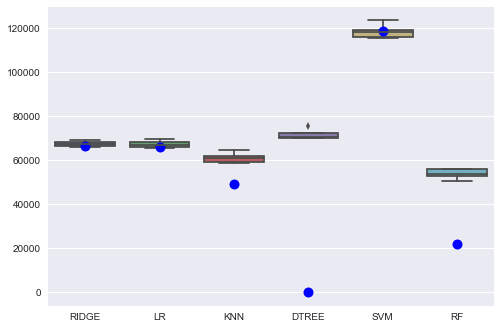

In [29]:
#Visualize
sns.boxplot(data=CVResults)
plt.plot(range(len(modelkeys)),TResults.iloc[0,:],'bo',markersize=10)

We can see from the untuned models both the bias and variance. The ones with high bias (poor training and C-V scores) indicates they're underfitting the data. Common ways to improve this are to increase the parameters of the model by increasing the features or decreasing the degree of regularization. 

We'll now look at fine-tuning some of the models.

## 12. Fine-tuning hyperparameters <a class="anchor" id="gridsearch"></a>
[[back to top]](#top)

### Grid Search

**`GridSearchCV`** is a tool to evaluate through hyperparameters using cross-validation. We'll use an example below with RandomForestRegressor:

In [30]:
from sklearn.model_selection import GridSearchCV

# Cosntruct pipeline
rf_pipe = Pipeline([("features",clone(full_pipeline) ), ("RF", RandomForestRegressor())])

# Parameter grid to perform evaluations at
param_grid = [ {'RF__n_estimators': [10,30], 'RF__max_features' :[4,6,8]}, 
               {'RF__bootstrap': [False], 'RF__n_estimators':[3,10], 'RF__max_features':[2,3,4] }
             ]

gs_rf = GridSearchCV(rf_pipe,param_grid,cv=5,scoring='neg_mean_squared_error')
gs_rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'], dtype=object...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'RF__n_estimators': [10, 30], 'RF__max_features': [4, 6, 8]}, {'RF__bootstrap': [False], 'RF__n_estimators': [3, 10], 'RF__max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In the above grid search we are evaluating  12 combinations of `n_estimators` and `max_features` in the first dictionary, and then 6 combinations of the hyperparameters with the bootstrap hyperparameter set to False. In total it will look at 18 combinations of the hyperparameters for the regressor, and train each model 5 times for cross-validation, so a total of 90 training rounds.

Below we write a simple function to report the best parameter found:

In [31]:
# Utility function to report best scores
def report(results, n_top=3,rmse=False):
    # if RMSE is true will take square root
    exp=0.5 if rmse else 1.0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  (-1*results['mean_test_score'][candidate])**exp,
                  (results['std_test_score'][candidate])**exp  ))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
#Print scores
rf_results =  gs_rf.cv_results_
report(rf_results,rmse=True)
#Show best random forest estimator
gs_rf.best_estimator_.steps[-1]

Model with rank: 1
Mean validation score: 50154.482 (std: 13282.491)
Parameters: {'RF__max_features': 8, 'RF__n_estimators': 30}

Model with rank: 2
Mean validation score: 50267.816 (std: 13329.176)
Parameters: {'RF__max_features': 6, 'RF__n_estimators': 30}

Model with rank: 3
Mean validation score: 50516.498 (std: 12428.531)
Parameters: {'RF__max_features': 4, 'RF__n_estimators': 30}



('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))

We obtain the best estimator with **`boostrap`** set to True and **`max_features`** and **`n_estimators`** hyperparameters set to 8 and 30 respectively. We see a decrease in the RMSE as we would hope for.


### Additional tuning:
Let's look into the hyperparameters we created for adding features such as `bedroom_per_rooms`, etc. and see if we can find out whether adding helps for the regression model.

In [32]:
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([("features",clone(full_pipeline) ), ("RF", RandomForestRegressor())])

param_grid = [ { 'features__num_pipeline__attrib_adder__add_pop_per_household':[True,False],
                'features__num_pipeline__attrib_adder__add_bedrooms_per_room':[True,False],
                'features__num_pipeline__attrib_adder__add_rooms_per_household':[True,False],
                'RF__n_estimators': [30,50], 'RF__max_features' :[8,10]},
             ]

gs_rf = GridSearchCV(rf_pipe,param_grid,cv=5,scoring='neg_mean_squared_error')
gs_rf.fit(X_train,y_train)
#Print scores
rf_results =  gs_rf.cv_results_
report(rf_results,rmse=True)
#Show best random forest estimator
gs_rf.best_estimator_.steps[-1]

Model with rank: 1
Mean validation score: 49427.205 (std: 13703.819)
Parameters: {'RF__max_features': 8, 'RF__n_estimators': 50, 'features__num_pipeline__attrib_adder__add_bedrooms_per_room': False, 'features__num_pipeline__attrib_adder__add_pop_per_household': True, 'features__num_pipeline__attrib_adder__add_rooms_per_household': True}

Model with rank: 2
Mean validation score: 49449.790 (std: 13235.672)
Parameters: {'RF__max_features': 8, 'RF__n_estimators': 50, 'features__num_pipeline__attrib_adder__add_bedrooms_per_room': False, 'features__num_pipeline__attrib_adder__add_pop_per_household': False, 'features__num_pipeline__attrib_adder__add_rooms_per_household': False}

Model with rank: 3
Mean validation score: 49518.265 (std: 13465.763)
Parameters: {'RF__max_features': 8, 'RF__n_estimators': 50, 'features__num_pipeline__attrib_adder__add_bedrooms_per_room': True, 'features__num_pipeline__attrib_adder__add_pop_per_household': True, 'features__num_pipeline__attrib_adder__add_rooms_pe

('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))

Interesting for the random forest, with the additional tuning, the hyperparameters that result in the best performance includes the addition of `pop_per_household` and `rooms_per_household`. 

### Randomized Grid Search

When the hyperaparameter space is large it is often best to use `RandomizedSearchCV` instead. It evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. You have more control over the computing budget to allocate to hyperparameter search by setting the number of iterations.

Below we will test it out on the **Support Vector Machine regressor** to see if we can improve its model performance. `RandomizedSearchCV` unlike `GridSearchCV` can take parameter distributions from `scipy` to grab randomly from. The two parameter distributions in `SVR` that we'll be searching are for `C` and `gamma` which are the penalty/regularization and kernel coefficient (only for `'rbf'` and `'poly'` not `'linear'` kernels) parameters. 

Before we try `RandomizedSearchCV` we'll look at the parameter distributions we're drawing them from:

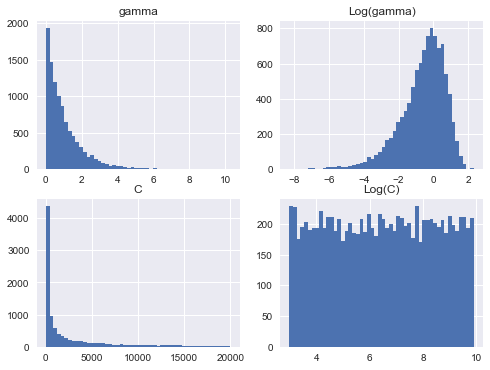

In [33]:
from scipy.stats import reciprocal,expon

fig,(axes) = plt.subplots(2,2,figsize=(8,6))
ax1,ax2,ax3,ax4 = axes.ravel()
# gamma distribution
gamma_distrib  = expon(scale=1.)
gamma_samples = gamma_distrib.rvs(10000)
# C distribution
C_distrib = reciprocal(20,20000)
C_samples = C_distrib.rvs(10000)
# Plot histograms
ax1.hist(gamma_samples,bins=50);ax2.hist(np.log(gamma_samples),bins=50)
ax1.set_title('gamma');ax2.set_title('Log(gamma)')
ax3.hist(C_samples,bins=50);ax4.hist(np.log(C_samples),bins=50)
ax3.set_title('C');ax4.set_title('Log(C)')

The exponential distribution we used for `gamma` has `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4. The distribution used for `C` looks as the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.


In [34]:
from sklearn.model_selection import RandomizedSearchCV

svm_pipe = Pipeline([("features",clone(full_pipeline) ), ("svm", SVR())])

param_grid = {'svm__kernel': ['rbf','linear'], 
              'svm__C': reciprocal(20, 200000),
              'svm__gamma':expon(scale=1.0) 
             }      

gs_svm = RandomizedSearchCV(svm_pipe,param_grid,n_iter=50,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
gs_svm.fit(X_train,y_train)
#Print scores
svm_results =  gs_svm.cv_results_
report(svm_results,rmse=True)
#Show best random forest estimator
gs_svm.best_estimator_.steps[-1]

Model with rank: 1
Mean validation score: 56809.622 (std: 15702.358)
Parameters: {'svm__C': 41949.809912834717, 'svm__gamma': 0.23039911415405021, 'svm__kernel': 'rbf'}

Model with rank: 2
Mean validation score: 57487.192 (std: 15777.965)
Parameters: {'svm__C': 99896.681020572127, 'svm__gamma': 0.56422299160297584, 'svm__kernel': 'rbf'}

Model with rank: 3
Mean validation score: 59169.244 (std: 16472.799)
Parameters: {'svm__C': 41960.495962537709, 'svm__gamma': 0.59715839030809015, 'svm__kernel': 'rbf'}



('svm',
 SVR(C=41949.809912834717, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma=0.23039911415405021, kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False))

Can see form the above that we get a RMSE for the best estimator that is closer to the Random Forest regressor. The best parameters above are the `rbf` kernel and `C` and `gamma` values around 16000 and 0.3. We could then perform a grid search after the random search to better tune the hyperparameter values.

## 13. Analyzing the best estimators<a class="anchor" id="bestestimators"></a>
[[back to top]](#top)


Some of the estimators have information on the relative importance of each attribute for making accurate predictions. One of these is the **`RandomForestRegressor`** used earlier:

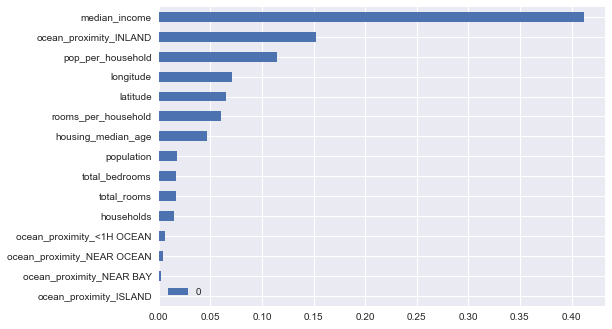

In [35]:
# RF feature importance
feature_importances = gs_rf.best_estimator_.steps[-1][-1].feature_importances_
feats = np.concatenate( (num_feats,['rooms_per_household','pop_per_household'],['ocean_proximity_<1H OCEAN','ocean_proximity_INLAND','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN']))
featimpt = pd.DataFrame(feature_importances,feats)
# Plotting
featimpt.sort_values(by=0,ascending=True).plot(kind='barh')


We see from the above that `median_income` is the best estimator for the Random Forest regression, and then whether the location is inland or not. The other `ocean_proximity` values turn out to not be great estimators as we thought, at least for Random Forest model. 

We could use these in our data preperation step to select only the *K* top ones.

## 14. Evaluate system on test data<a class="anchor" id="evaluatetest"></a>
[[back to top]](#top)

Now we will use the test data we withheld at the start to evaluate the performance. We will use the best estimator from the random forest grid search we performed earlier.

In [36]:
final_model = gs_rf.best_estimator_
predictions = final_model.predict(X_test)
final_mse   = mean_squared_error(y_test,predictions)
print('Test data RMSE: ',np.sqrt(final_mse))

Test data RMSE:  47654.2885178


We see that the performance is within the range from the grid search cross-valdiation with an RMSE of `$48,241`.


## 15. Summary <a class="anchor" id="summary"></a>
[[back to top]](#top)

Although we did not perform extensive hyperparameter tuning over many models and ensembles, we can draw a few conclusions from what we have learned by working with the California Housing dataset. If we want to estimate the `median_house_value` for any given district:

1. The most important predictor of a given district for determining the median house value is the median income of the home owners within the district. 

2. The proximity to the ocean, at first intuitively seemed like a good predictor, but turned out that the learning algorithm determined that the binary encoding of whether the district is inland or not was important and not near the bay or ocean.

3. A limitation of the dataset, as noted earlier, is that the house values are capped at $500,000 when there are probably some districts well over this number. If it is essential that the predictions be able to capture values higher than the cappped limit, then we would have to change the data preperation. 


## License
The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/). 
